# Agrupamiento conocido - Basado en probabilidad: Algoritmo EM

### Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.cluster.hierarchy import linkage, fcluster, cut_tree, dendrogram
from sklearn.mixture import GaussianMixture
import itertools as it


### Carga de datos


In [2]:
#Carga de datos
np.random.seed(31) # Fijamos una semilla para asegurar la reproducibilidad de la práctica
data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_cuatro_diferente_densidad.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
# Valores de la clase
Dy = D[:,2]


### Descripción de los datos cargados

El dataset cargado tiene 1999 instancias.
 
Matriz original D:  [[ 51.72   5.     2.  ]
 [ 47.93   5.     2.  ]
 [220.39   7.     3.  ]
 ...
 [ 30.15   6.     2.  ]
 [ 49.9    6.     2.  ]
 [ 40.66   7.     2.  ]]
 
Matriz sin los valores de la clase:  [[ 51.72   5.  ]
 [ 47.93   5.  ]
 [220.39   7.  ]
 ...
 [ 30.15   6.  ]
 [ 49.9    6.  ]
 [ 40.66   7.  ]]


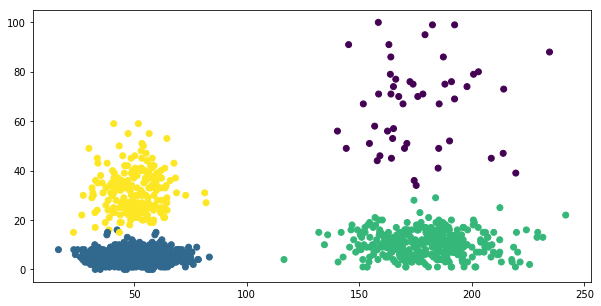

In [8]:
print('El dataset cargado tiene',Dy.size,'instancias.')
print(' ')
print ('Matriz original D: ', D)
print(' ')
print ('Matriz sin los valores de la clase: ', Dx)
#print(' ')
#print ('Matriz de los valores de la clase: ',  Dy)

#fig, ax = plt.subplots(figsize=(10,5))
#ax.scatter(Dx[:,0],Dx[:,1], c=Dy)
#ax.set_title('Clasificación real del dataset')
#fig.text=''

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)
fig.text=''

### Ejecución del algoritmo y resultados

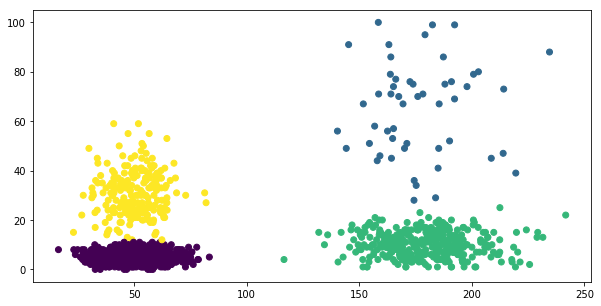

In [7]:
# Se inicializa el método con el número de clústeres (componentes) a buscar
modelo = GaussianMixture(n_components = 4, max_iter = 1000)
# Se aprende el modelo
modelo = modelo.fit(Dx)
# Se predicen las asignaciones a clústeres
Dyp = modelo.predict(Dx)

# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
fig.text=''

### Comparación de resultados estimados con valores reales

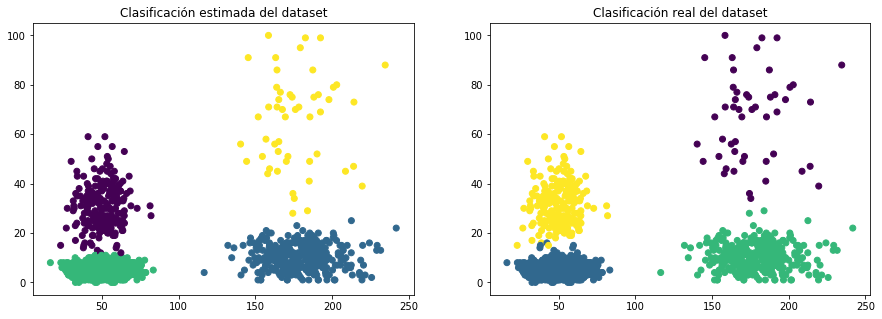

In [5]:
# Visualizamos gráficamente los datos 
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('Clasificación estimada del dataset')
ax1.scatter(Dx[:,0],Dx[:,1], c=Dyp)

ax2.set_title('Clasificación real del dataset')
ax2.scatter(Dx[:,0],Dx[:,1], c=Dy)
fig.text=''

### Métricas intrínsecas

In [9]:
def distancia_euclidiana(x, y):   
    return np.sqrt(np.sum((x - y) ** 2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD

def calcular_matriz_a(X, Xyp, mD):
    labels = np.sort(np.unique(Xyp))
    factores = 1.0/(np.array([np.sum(Xyp==labels[k]) for k in np.arange(labels.size)])-1)
    aX = np.zeros(X.shape[0])
    for i in np.arange(X.shape[0]):
        k = Xyp[i]
        aX[i] = factores[k] * np.sum([mD[i,ip] 
                                      for ip in np.arange(X.shape[0])[Xyp==labels[k]]])
    return(aX)

def calcular_matriz_b(X, Xyp, mD):
    labels = np.sort(np.unique(Xyp))
    factores = 1.0/np.array([np.sum(Xyp==labels[k]) for k in np.arange(labels.size)])
    bX = np.zeros(X.shape[0])
    for i in np.arange(X.shape[0]):
        k = Xyp[i]
        ran = np.arange(labels.size)
        ran = ran[np.arange(labels.size)!=k]
        res = np.array([factores[h] * np.sum([mD[i,ip]
                                              for ip in np.arange(X.shape[0])[Xyp==labels[h]]])
                        for h in ran])
        bX[i] = np.min(res)
    return(bX)

def medida_silueta(X, Xyp, distancia):
    mD = matriz_distancias(X, distancia)
 

    A = calcular_matriz_a(X, Xyp, mD)
    B = calcular_matriz_b(X, Xyp, mD)
    impl = (B-A)/np.maximum(A,B)    

    return np.mean(impl)
    

print('El valor de la medida Silueta es = ', medida_silueta(Dx, Dyp, distancia_euclidiana))



El valor de la medida Silueta es =  0.5753189816643997


### Métricas extrinsecas

In [10]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i], cat_pred==clusts[j])) 
                     for j in np.arange(clusts.size)] 
                    for i in np.arange(cats.size)])
    return(mat)

def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([totales[k] * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:]))

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2*prec*rec/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

mC = matriz_confusion(Dy,Dyp)

print(mC)
print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC))
print('El valor F1 es = ', medida_f1(mC))

[[   0   49    0    0]
 [1385    0    0    8]
 [   0    2  344    0]
 [   0    0    0  211]]
El valor del error cometido es =  0.005002501250625291
La pureza del agrupamiento obtenido es =  0.9949974987493748
El valor F1 es =  0.99503751924735


### Conclusión

El agrupamiento obtenido es muy bueno, si observamos el valor de la métrica F1 podemos ver que es casi 1, el de kmeans++ es un poco superior pero hay una diferencia mínima.